# Basic transfer learning with cats and dogs data

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow-Advanced_Techniques_Specialization/blob/master/Advanced_Computer_Vision_with_TensorFlow/Week1/Labs/C3_W1_Lab_1_transfer_learning_cats_dogs.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

### Import modules

In [1]:
import urllib.request
import os
import zipfile
import random
from shutil import copyfile
from keras import utils, Sequential, layers, applications, Model, optimizers
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

2024-08-27 20:55:52.533995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 20:55:52.546856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 20:55:52.550495: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 20:55:52.559108: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Download the cats and dogs dataset

In [2]:
data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
data_file_name = "./catsdogs.zip"
download_dir = './'
urllib.request.urlretrieve(data_url, data_file_name)
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

Remove corrupted files.

In [3]:
paths = ['./PetImages/Cat/', './PetImages/Dog/']

for path in paths:
    for file in os.listdir(path):
        try:
            if file.endswith(".jpg"):
                img = tf.io.read_file(str(path + file))
                img = tf.image.decode_image(img)
                if img.shape[2] != 3:
                    os.remove(path + file)
        except:
            os.remove(path + file)

2024-08-27 20:57:53.873926: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2129 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
2024-08-27 20:57:57.844707: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
2024-08-27 20:57:58.087186: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input size should match (header_size + row_size * abs_height) but they differ by 2
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
2024-08-27 20:

Check that the dataset has the expected number of examples.

In [4]:
print("Number of cat images:", len(os.listdir('./PetImages/Cat/')))
print("Number of dog images:", len(os.listdir('./PetImages/Dog/')))

# Expected Output:
# Number of cat images: 12501
# Number of dog images: 12501

Number of cat images: 12469
Number of dog images: 12461


Create some folders that will store the training and test data.
- There will be a training folder and a testing folder.
- Each of these will have a subfolder for cats and another subfolder for dogs.

In [5]:
try:
    os.mkdir('./cats-v-dogs')
    os.mkdir('./cats-v-dogs/training')
    os.mkdir('./cats-v-dogs/testing')
    os.mkdir('./cats-v-dogs/training/cats')
    os.mkdir('./cats-v-dogs/training/dogs')
    os.mkdir('./cats-v-dogs/testing/cats')
    os.mkdir('./cats-v-dogs/testing/dogs')
except OSError:
    pass

### Split data into training and test sets

- The following code put first checks if an image file is empty (zero length)
- Of the files that are not empty, it puts 90% of the data into the training set, and 10% into the test set.

In [6]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []

    for filename in os.listdir(SOURCE):
        file = SOURCE + filename

        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

CAT_SOURCE_DIR = "./PetImages/Cat/"
TRAINING_CATS_DIR = "./cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "./cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "./PetImages/Dog/"
TRAINING_DOGS_DIR = "./cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "./cats-v-dogs/testing/dogs/"

split_size = 0.9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

Check that the training and test sets are the expected lengths.

In [7]:
print("Number of training cat images", len(os.listdir('./cats-v-dogs/training/cats/')))
print("Number of training dog images", len(os.listdir('./cats-v-dogs/training/dogs/')))
print("Number of testing cat images", len(os.listdir('./cats-v-dogs/testing/cats/')))
print("Number of testing dog images", len(os.listdir('./cats-v-dogs/testing/dogs/')))

# Expected output
# Number of training cat images 11250
# Number of training dog images 11250
# Number of testing cat images 1250
# Number of testing dog images 1250

Number of training cat images 11222
Number of training dog images 11214
Number of testing cat images 1247
Number of testing dog images 1247


### Data augmentation (try adjusting the parameters)!

Here, you'll use the `ImageDataGenerator` to perform data augmentation.  
- Things like rotating and flipping the existing images allows you to generate training data that is more varied, and can help the model generalize better during training.  
- You can also use the data generator to apply data augmentation to the validation set.

You can use the default parameter values for a first pass through this lab.
- Later, try to experiment with the parameters of `ImageDataGenerator` to improve the model's performance.
- Try to drive reach 99.9% validation accuracy or better.

In [8]:
# Experiment with your own parameters to reach 99.9% validation accuracy or better
augmentation = Sequential([layers.Rescaling(scale=1. / 255),
                           layers.RandomRotation(0.2, fill_mode="nearest"),
                           layers.RandomTranslation(0.2, 0.2, fill_mode="nearest"),
                           layers.RandomZoom(0.2, 0.2, fill_mode="nearest"),
                           layers.RandomFlip(mode="horizontal")])
scale = layers.Rescaling(scale=1. / 255)

TRAINING_DIR = "./cats-v-dogs/training/"
train_generator = utils.image_dataset_from_directory(TRAINING_DIR,
                                                     batch_size=100,
                                                     label_mode='binary',
                                                     image_size=(150, 150))

VALIDATION_DIR = "./cats-v-dogs/testing/"
validation_generator = utils.image_dataset_from_directory(VALIDATION_DIR,
                                                          batch_size=100,
                                                          label_mode='binary',
                                                          image_size=(150, 150))

train_generator = train_generator.map(lambda image, label: (augmentation(image), label))
validation_generator = validation_generator.map(lambda image, label: (scale(image), label))

Found 22434 files belonging to 2 classes.
Found 2494 files belonging to 2 classes.


### Get and prepare the model

You'll be using the `InceptionV3` model.  
- Since you're making use of transfer learning, you'll load the pre-trained weights of the model.
- You'll also freeze the existing layers so that they aren't trained on your downstream task with the cats and dogs data.
- You'll also get a reference to the last layer, 'mixed7' because you'll add some layers after this last layer.

In [9]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "./inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

# Instantiate the model
pre_trained_model = applications.InceptionV3(input_shape=(150, 150, 3),
                                             include_top=False,
                                             weights=None)

# Load pre-trained weights
pre_trained_model.load_weights(weights_file)

# Freeze the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


### Add layers
Add some layers that you will train on the cats and dogs data.
- `Flatten`: This will take the output of the `last_layer` and flatten it to a vector.
- `Dense`: You'll add a dense layer with a relu activation.
- `Dense`: After that, add a dense layer with a sigmoid activation.  The sigmoid will scale the output to range from 0 to 1, and allow you to interpret the output as a prediction between two categories (cats or dogs).

Then create the model object.

In [10]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

### Train the model
Compile the model, and then train it on the test data using `model.fit`
- Feel free to adjust the number of epochs.  This project was originally designed with 20 epochs.
- For the sake of time, you can use fewer epochs (2) to see how the code runs.
- You can ignore the warnings about some of the images having corrupt EXIF data. Those will be skipped.

In [11]:
# Compile the model
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

# Train the model (adjust the number of epochs from 1 to improve performance)
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=2,
                    verbose=1)

Epoch 1/2


I0000 00:00:1724813912.450568    6997 service.cc:146] XLA service 0x70ade8044840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724813912.450605    6997 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-08-27 20:58:32.565669: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-27 20:58:33.386897: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-27 20:58:35.936176: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 828.57MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  1/225 ━━━━━━━━━━━━━━━━━━━━ 54:09 15s/step - acc: 0.5200 - loss: 0.6943

I0000 00:00:1724813922.929020    6997 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 21/225 ━━━━━━━━━━━━━━━━━━━━ 1:31 446ms/step - acc: 0.6773 - loss: 1.0619

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 45/225 ━━━━━━━━━━━━━━━━━━━━ 1:21 455ms/step - acc: 0.7355 - loss: 0.7972

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 47/225 ━━━━━━━━━━━━━━━━━━━━ 1:20 455ms/step - acc: 0.7387 - loss: 0.7838

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 53/225 ━━━━━━━━━━━━━━━━━━━━ 1:18 456ms/step - acc: 0.7474 - loss: 0.7482

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 97/225 ━━━━━━━━━━━━━━━━━━━━ 58s 459ms/step - acc: 0.7847 - loss: 0.5986

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


108/225 ━━━━━━━━━━━━━━━━━━━━ 53s 459ms/step - acc: 0.7909 - loss: 0.5757

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


111/225 ━━━━━━━━━━━━━━━━━━━━ 52s 459ms/step - acc: 0.7925 - loss: 0.5700

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


138/225 ━━━━━━━━━━━━━━━━━━━━ 39s 459ms/step - acc: 0.8045 - loss: 0.5271

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


145/225 ━━━━━━━━━━━━━━━━━━━━ 36s 459ms/step - acc: 0.8072 - loss: 0.5179

150/225 ━━━━━━━━━━━━━━━━━━━━ 34s 459ms/step - acc: 0.8090 - loss: 0.5117

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


155/225 ━━━━━━━━━━━━━━━━━━━━ 32s 460ms/step - acc: 0.8108 - loss: 0.5058

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


198/225 ━━━━━━━━━━━━━━━━━━━━ 12s 460ms/step - acc: 0.8231 - loss: 0.4645

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


212/225 ━━━━━━━━━━━━━━━━━━━━ 5s 460ms/step - acc: 0.8263 - loss: 0.4540

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


225/225 ━━━━━━━━━━━━━━━━━━━━ 137s 548ms/step - acc: 0.8291 - loss: 0.4446 - val_acc: 0.9683 - val_loss: 0.0815
Epoch 2/2
 19/225 ━━━━━━━━━━━━━━━━━━━━ 1:35 463ms/step - acc: 0.9119 - loss: 0.2208

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 46/225 ━━━━━━━━━━━━━━━━━━━━ 1:22 463ms/step - acc: 0.9114 - loss: 0.2169

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 49/225 ━━━━━━━━━━━━━━━━━━━━ 1:21 463ms/step - acc: 0.9113 - loss: 0.2171

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 63/225 ━━━━━━━━━━━━━━━━━━━━ 1:14 463ms/step - acc: 0.9105 - loss: 0.2182

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 93/225 ━━━━━━━━━━━━━━━━━━━━ 1:01 462ms/step - acc: 0.9101 - loss: 0.2191

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 96/225 ━━━━━━━━━━━━━━━━━━━━ 59s 463ms/step - acc: 0.9101 - loss: 0.2190 

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


101/225 ━━━━━━━━━━━━━━━━━━━━ 57s 463ms/step - acc: 0.9101 - loss: 0.2189

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


107/225 ━━━━━━━━━━━━━━━━━━━━ 54s 463ms/step - acc: 0.9101 - loss: 0.2189

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


137/225 ━━━━━━━━━━━━━━━━━━━━ 40s 463ms/step - acc: 0.9104 - loss: 0.2177

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


144/225 ━━━━━━━━━━━━━━━━━━━━ 37s 463ms/step - acc: 0.9105 - loss: 0.2174

158/225 ━━━━━━━━━━━━━━━━━━━━ 30s 463ms/step - acc: 0.9107 - loss: 0.2170

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


196/225 ━━━━━━━━━━━━━━━━━━━━ 13s 462ms/step - acc: 0.9108 - loss: 0.2160

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


201/225 ━━━━━━━━━━━━━━━━━━━━ 11s 462ms/step - acc: 0.9108 - loss: 0.2159

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


225/225 ━━━━━━━━━━━━━━━━━━━━ 106s 471ms/step - acc: 0.9108 - loss: 0.2154 - val_acc: 0.9679 - val_loss: 0.0729


### Visualize the training and validation accuracy

You can see how the training and validation accuracy change with each epoch on an x-y plot.

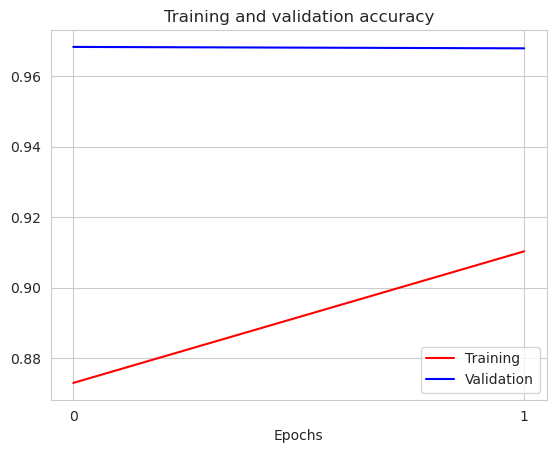

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
sns.set_style("whitegrid")
plt.figure()
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.xticks([0, 1])
plt.legend(["Training", "Validation"])
plt.show()
sns.set_style("white")

### Predict on a test image

You can upload any image and have the model predict whether it's a dog or a cat.
- Find an image of a dog or cat
- Run the following code cell.  It will ask you to upload an image.
- The model will print "is a dog" or "is a cat" depending on the model's prediction.

In [13]:
!wget -q https://upload.wikimedia.org/wikipedia/commons/9/99/Brooks_Chase_Ranger_of_Jolly_Dogs_Jack_Russell.jpg -O ./cats-v-dogs/dog.jpg

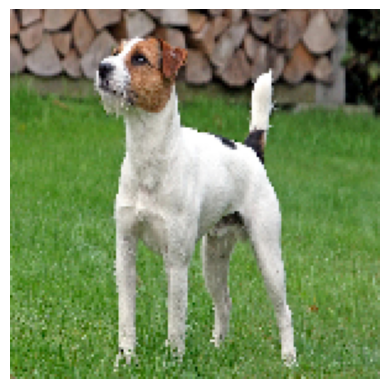

./cats-v-dogs/dog.jpg is a dog


In [14]:
# Predicting images
path = "./cats-v-dogs/dog.jpg"
img = utils.load_img(path, target_size=(150, 150))
x = utils.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

plt.figure()
plt.imshow(img)
plt.axis("off")
plt.show()

image_tensor = np.vstack([x])
classes = model.predict(image_tensor, verbose=0)

if classes[0] > 0.5:
    print(path + " is a dog")
else:
    print(path + " is a cat")

In [15]:
!rm -rf ./cats-v-dogs ./PetImages ./*.zip ./*.h5 ./*.txt ./*.pdf